# Sprint 13 Final Project

## Introduction
---
In this project we'll be working with <em>Sweet Lift Taxi</em> assisting them in predicting the amount of taxi orders for the next hour to attract more drivers for peak hours. To do so, we'll analyze their data of historical orders at airports. We'll build a time series model to produce such predictions.

The dataset we'll be working with can be found here: <a href='https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv'>https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv</a>

This project will consist of the following:<ul>
- Data Overview<br>
- Time Series Analysis<br>
- Model Creation<br>
- Model Testing<br>
- Conclusion<br>
    
__NOTE__: You may have to restart kernel for notebook to recognize the sktime library

In [1]:
pip install --upgrade sktime


Note: you may need to restart the kernel to use updated packages.


## Data Overview
---

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic, adfuller
from statsmodels.tsa.tsatools import detrend
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler
from pmdarima import auto_arima
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from pmdarima.preprocessing import BoxCoxEndogTransformer
from sktime.split import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.base import BaseEstimator
from sktime.utils.plotting import plot_windows
from sktime.datatypes import scitype

In [3]:
sns.set_style("darkgrid")

In [4]:
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv',index_col=[0],parse_dates=[0])
df.sort_index(inplace=True)
df.info(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


We have a dataset within a 6 month period at 10 minute intervals with minimun value(s) 0f 0 and max of 119. The data is slightly skewed to the right.

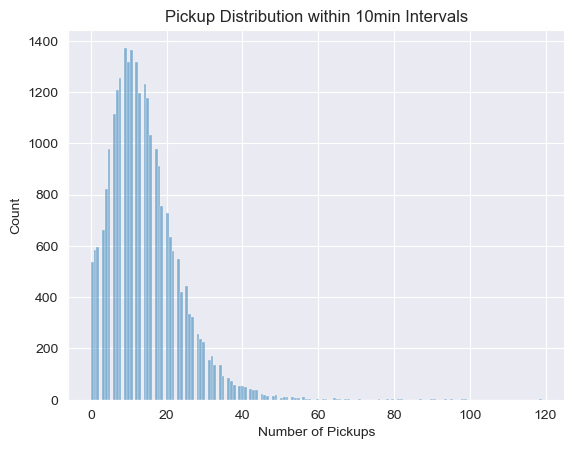

In [7]:
plt.figure()

sns.histplot(df,legend=False)

plt.xlabel("Number of Pickups")
plt.title("Pickup Distribution within 10min Intervals")

plt.show()

In [8]:
# Creating new columns with mean and variance 
data = df.resample('1h').sum()
data['rolling_mean'] = data.shift().rolling(7).mean()
data['rolling_std'] = data['num_orders'].shift().rolling(7).std()
birds_eye = df.resample('1D').sum()
birds_eye['mean'] = birds_eye.shift().rolling(7).mean()
birds_eye['std'] = birds_eye['num_orders'].shift().rolling(7).std()

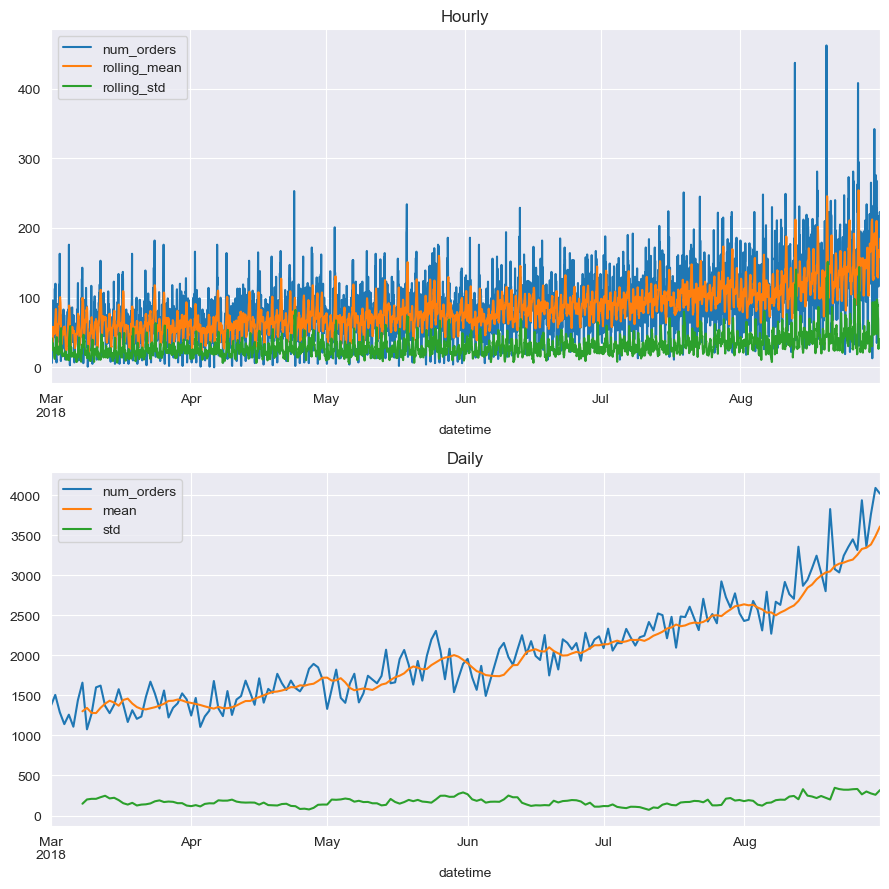

In [9]:
fig,axes = plt.subplots(2,1,figsize=(9,9))
data.plot(ax=axes[0])
birds_eye.plot(ax=axes[1])
axes[0].set_title('Hourly')
axes[1].set_title('Daily')
plt.tight_layout()
plt.show()

We've plotted the resampled data for total hourly (figure 1) and daily orders (figure 2) along with their respective rolling means and standard deviations with window sizes of 7. The figure shows an impressive increase in orders over the months. I'd attribute it to better weather for travel in addition to school summer breaks/vacations. 

The total orders for the incoming week likely to stay above 3500 from the looks of the the moving average on figure 2.

Let's check out the seasonality and trends and look at the most recent month of activity to get a better insight.

In [10]:
decomposed = seasonal_decompose(data['num_orders'])

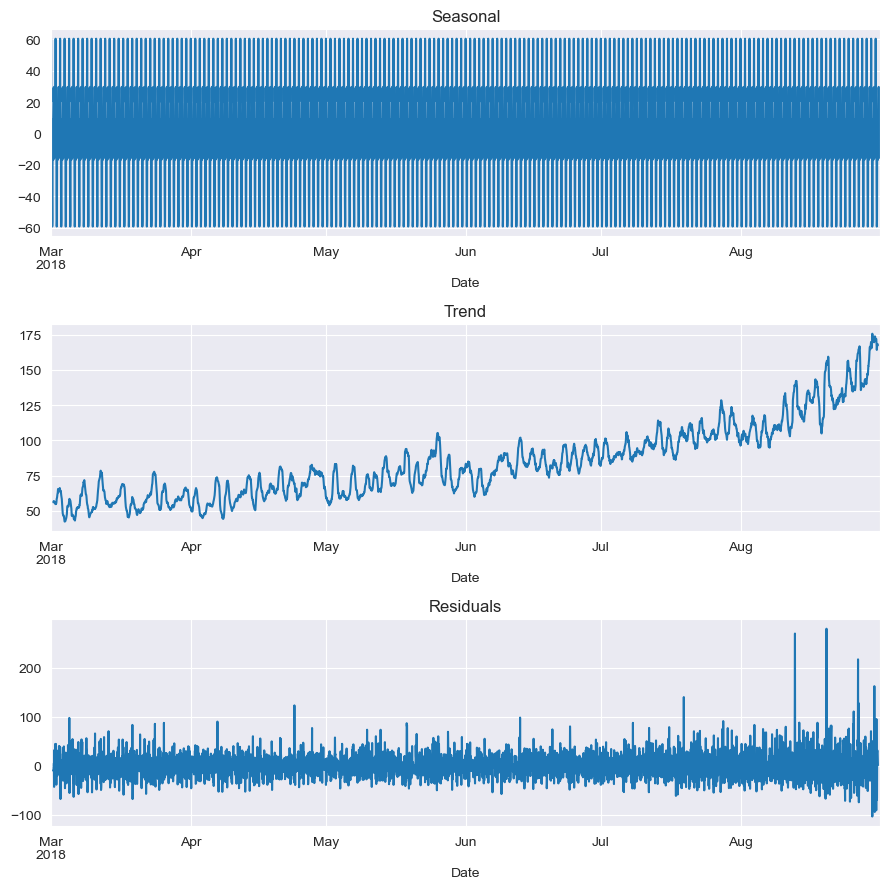

In [11]:
plt.figure(figsize=(9,9))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel("Date")

plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel("Date")


plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals')
plt.xlabel("Date")


plt.tight_layout()
plt.show()

In [12]:
# Confirming accuracy
print(decomposed.trend[4:6] + decomposed.seasonal[4:6] + decomposed.resid[4:6],'\n')
print(data[4:6]['num_orders'])      

datetime
2018-03-01 04:00:00   NaN
2018-03-01 05:00:00   NaN
Freq: h, dtype: float64 

datetime
2018-03-01 04:00:00    43
2018-03-01 05:00:00     6
Freq: h, Name: num_orders, dtype: int64


The seasonal plot shows a constant pattern with a steep upward trend towards the last month.


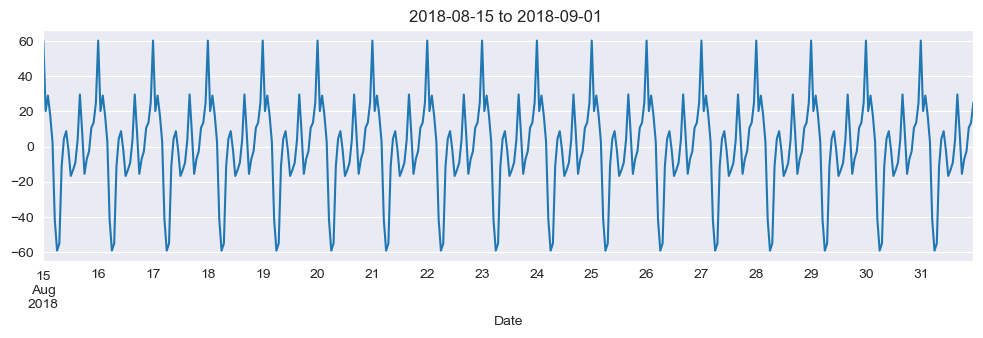

In [13]:
# Zooming into the seasonality
plt.figure(figsize=(12,3))

decomposed.seasonal['2018-08-15':'2018-09-01'].plot()
plt.title('2018-08-15 to 2018-09-01 ')
plt.xlabel("Date")

plt.show()

Can't distinguish any patters when looking at the entirety of the data but when we zoom into the most recent week we notice see a pattern. There are heavy, but consistent swings thoughout. This shows some predictability in the data.

We'll now use one-lag differencing to get a stationary series for forecasting. We'll start by keeping our focus on the most recent 15 days.

In [14]:
data['num_orders']

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: h, Name: num_orders, Length: 4416, dtype: int64

<Axes: xlabel='datetime'>

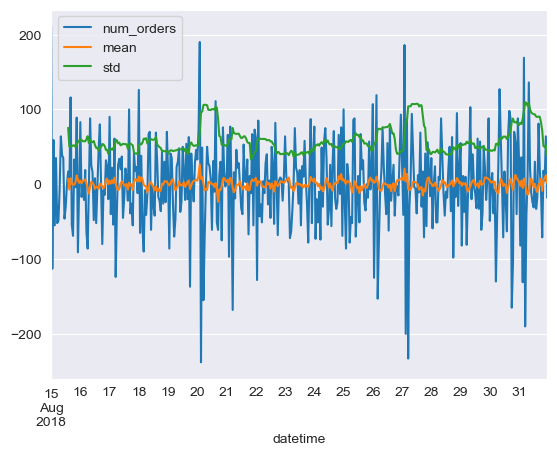

In [15]:
stationary = df['2018-08-15':'2018-09-01'].resample('1h').sum()
stationary -= stationary.shift(fill_value=0)
stationary['mean'] = stationary['num_orders'].rolling(15).mean()
stationary['std'] = stationary['num_orders'].rolling(15).std()
stationary.plot()

Now that we've removed the trends and seasonality, we can see consistency within the number of orders, rolling averages and standard deviation. This gives our regression models a better ability to draw some linear correlations that will help with the model predictions.

Let's prepare for our model next.

## Model Creation
---
We'll create the following features to will help with our model training:
- month
- day of week
- lag 1, 2, 3
- rolling mean

In [16]:
# Creating dummy variable
data = df.resample('1h').sum()

# Defining function for feature creation
def create_feats(df,max_lag,window_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag +1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(window_size).mean()

In [17]:
# Adding features to dataset
create_feats(data,3,6)
data.head(7)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,NaN
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,NaN
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,65.833333


#### Linear Regression
We'll do some prepping of the data to run through a Linear Regression model

In [18]:
# Creating train, validateion and test sets at a 80-10-10 ratio
train, test = train_test_split(data,shuffle=False,test_size = 0.2)
valid, test = train_test_split(test,shuffle=False,test_size=0.5)

# Confirming sets in chronological order
print(train.index.min(),train.index.max())
print(valid.index.min(),valid.index.max())
print(test.index.min(),test.index.max())

2018-03-01 00:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [19]:
# Dropping rows with NaN values
train = train.dropna()
train.head(3)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,65.833333
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,47.166667
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,35.500000


In [20]:
# Splitting sets into features and targets sets
train_features = train.drop('num_orders',axis=1)
train_target = train['num_orders']
valid_features = valid.drop('num_orders',axis=1)
valid_target = valid['num_orders']
test_features = test.drop('num_orders',axis=1)
test_target = test['num_orders']

In [21]:
print(train_features.shape,train_target.shape)
print(valid_features.shape,valid_target.shape)
print(test_features.shape,test_target.shape)

(3526, 7) (3526,)
(442, 7) (442,)
(442, 7) (442,)


In [22]:
# Initializing scaler
scaler = MaxAbsScaler()
# Scaling features
scaled_X_train = scaler.fit_transform(train_features)
scaled_X_valid = scaler.transform(valid_features)
scaled_X_test = scaler.transform(test_features)

In [23]:
# Initializing Linear Regression model
lr = LinearRegression()

# Fitting model
lr.fit(scaled_X_train,train_target)

LinearRegression()

In [24]:
pred = lr.predict(scaled_X_valid)
print('RMSE on subset: ',np.sqrt(mean_squared_error(valid_target,pred)).round(3))

RMSE on subset:  40.399


Linear Regression showing horrid performance here. This model is clearly not a good fit for time series problems.

We'll move on to the next model, AutoRegressive

#### AutoRegressive

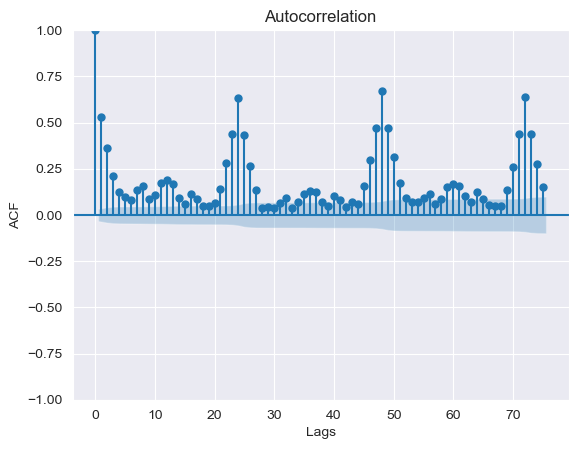

In [25]:
# Building AutoArima model
num_lags = 75 # Plotting acf
acf = plot_acf(x=train_target,lags=num_lags)

plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

A bit difficult to get a precise acf value by eyeing the plot sometimes but it appears to be near 30. We'll use a tool later to get the precise number. We'll move on to plotting the pacf.

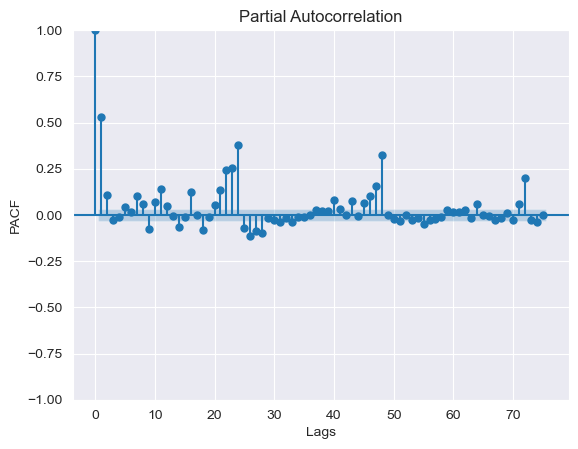

In [26]:
# Plotting PCF 
pacf = plot_pacf(x=train_target,lags=num_lags)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

These ACF anf PACF plots helps us define lags with statistical significance. These plots help us have a good idea on deciding arguments for the max lag parameters ahead.

Our partial correlation plot show us the number of lags with statistical significance is 2, as we ignore the first value.

We'll use the ar_select_order tool from the statsmodels.tsa.ar_model module to find a precise order of data's ACF and PACF for model parameters.

In [27]:
# Assigning order selection function to variable
mod = ar_select_order(endog=train_target,exog=scaled_X_train,maxlag=num_lags)

# Extracting lags to define AR model
ar_order = mod.ar_lags

In [28]:
# Initializing AR model
ar_model = AutoReg(endog=train_target,exog=scaled_X_train,lags=ar_order,seasonal=True,trend='ct')

In [29]:
ar_model = ar_model.fit()

In [30]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                             
===============================================================================
Dep. Variable:              num_orders   No. Observations:                 3526
Model:             Seas. AutoReg-X(72)   Log Likelihood              -15343.677
Method:                Conditional MLE   S.D. of innovations             20.560
Date:                 Sun, 31 Aug 2025   AIC                          30897.354
Time:                         18:18:33   BIC                          31542.820
Sample:                     03-04-2018   HQIC                         31127.868
                          - 07-26-2018                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -263.5438    137.642     -1.915      0.056    -533.317       6.229
trend             -0.1090      0.062     -1.750      0.080      -0.231       0.013
s(2,24)            6.6017      3.313      1.993      0.046       0.108      13.095
s(3,24)           34.4749      4.006      8.606      0.000      26.623      42.326
s(4,24)           37.4706      4.536      8.260      0.000      28.579      46.362
s(5,24)           36.0333      4.776      7.544      0.000      26.672      45.395
s(6,24)           26.4064      4.745      5.566      0.000      17.107      35.706
s(7,24)           16.9334      4.620      3.665      0.000       7.878      25.989
s(8,24)           23.0075      4.512      5.100      0.000      14.165      31.850
s(9,24)           28.9475      4.306      6.722      0.000      20.507      37.388
s(10,24)          34.0756      4.644      7.338      0.000      24.974      43.178
s(11,24)          50.3776      4.725     10.661      0.000      41.116      59.639
s(12,24)          35.9646      4.765      7.548      0.000      26.626      45.303
s(13,24)          29.8916      4.839      6.177      0.000      20.408      39.375
s(14,24)          34.5234      4.782      7.220      0.000      25.152      43.895
s(15,24)          34.4752      4.790      7.197      0.000      25.087      43.863
s(16,24)          34.5997      4.742      7.297      0.000      25.306      43.893
s(17,24)          37.6890      4.435      8.499      0.000      28.997      46.381
s(18,24)          40.7011      4.648      8.757      0.000      31.592      49.811
s(19,24)          58.5609      4.623     12.668      0.000      49.501      67.621
s(20,24)          29.7108      4.757      6.246      0.000      20.388      39.034
s(21,24)          32.1345      4.797      6.699      0.000      22.733      41.536
s(22,24)          25.6690      4.568      5.620      0.000      16.717      34.621
s(23,24)          16.7271      4.044      4.136      0.000       8.801      24.653
s(24,24)          -0.3008      3.322     -0.091      0.928      -6.812       6.210
num_orders.L1      0.1212      0.017      7.183      0.000       0.088       0.154
num_orders.L2      0.1100      0.017      6.461      0.000       0.077       0.143
num_orders.L3      0.0603      0.017      3.528      0.000       0.027       0.094
num_orders.L4      0.0529      0.017      3.091      0.002       0.019       0.087
num_orders.L5      0.0151      0.017      0.880      0.379      -0.019       0.049
num_orders.L6     -0.0265      0.017     -1.543      0.123      -0.060       0.007
num_orders.L7      0.0806      0.017      4.696      0.000       0.047       0.114
num_orders.L8      0.0588      0.017      3.419      0.001       0.025       0.093
num_orders.L9     -0.0163      0.017     -0.944      0.345      -0.050       0.018
num_orders.L10     0.0036      0.017      0.210      0.834      -0.030       0.037
num_orders.L11     0.0509      0.017      2.951      0.003       0.017       0

In [31]:
param = ar_model.params

In [32]:
# Getting predictions using training subset
pred = ar_model.predict(exog_oos=scaled_X_valid,start=valid.index.min(),end=valid.index.max())

# Getting RSME score
print('AutoRegressive RSME: ',np.sqrt(mean_squared_error(valid_target,pred)).round(3))

AutoRegressive RSME:  34.732


Much better than the the linear regression model. We'll see how this compares with the AutoArima model.

#### ARIMA

In [33]:
# Initializing and training auto ARIMA model
arima_model = auto_arima(y=train_target,X=scaled_X_train,random_state=12345)

In [34]:
# Fitting model
arima_model = arima_model.fit(X=scaled_X_train,y=train_target)

In [35]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3526
Model:                        SARIMAX   Log Likelihood              -16884.102
Date:                Sun, 31 Aug 2025   AIC                          33786.204
Time:                        18:18:58   BIC                          33841.715
Sample:                    03-01-2018   HQIC                         33806.008
                         - 07-26-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3056      2.428      4.245      0.000       5.547      15.064
x1            46.6635      2.941     15.869      0.000      40.900      52.427
x2            10.9206      1.849      5.907      0.000       7.297      14.544
x3             0.3307      1.490      0.222      0.824      -2.590       3.252
x4           113.0725      3.984     28.384      0.000     105.265     120.880
x5            30.2384      4.829      6.261      0.000      20.773      39.704
x6            -5.7880      5.533     -1.046      0.296     -16.633       5.057
x7           -32.1801      6.995     -4.601      0.000     -45.889     -18.471
sigma2       844.7400     17.205     49.098      0.000     811.019     878.462
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               393.75
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The auto arima model has found the SARIMAX model as best fit. Let's get a score and compare with the other models.

In [36]:
pred = arima_model.predict(n_periods=len(valid),X=scaled_X_valid)

In [37]:
print('SARIMAX RSME: ',np.sqrt(mean_squared_error(valid_target,pred)).round(3))

SARIMAX RSME:  40.401


Not the direction we'd like to go here with an identical performance as the linear regression model. We'll move on to the Naive Forecaster model from the sktime library.

#### NaiveForcaster
Well utilize a naive forecaster in the sktime library. We'll use a gridsearch equivalent named ForecastingGridSearchCV as a means for hypertuning.

In [38]:
# Creating dictionary of hyperparamenter and arguments for time series gridsearch
params = {
    'strategy' : ['last','mean'],
    'window_length' : np.arange(79,91,3)
}
fh = np.arange(1,443) # Creating forecasting horizon instance
cv = SlidingWindowSplitter(
    fh = fh,
    window_length = 2210,
    step_length = 6,
    start_with_window = True
)
# Setting estimator for time eries gridsearch
naive_forecaster = NaiveForecaster()

naive_cv = ForecastingGridSearchCV(
    forecaster = naive_forecaster,
    param_grid = params,
    cv = cv,
    scoring = None,
    verbose = 1
)

This plot demonstrates the model's window of data used training (blue) and testing(yellow) within the training data as a way to self evaluate and adjust to reduce error. It keeps running iterations through the entirety of the training set.

In [39]:
# Changing dtypes to adhere to model requirements
train_features32, train_target32 = scaled_X_train.astype('float32'), train_target.astype('float32')
valid_features32, valid_target32 = scaled_X_valid.astype('float32'), valid_target.astype('float32')
test_features32, test_target32 = scaled_X_test.astype('float32'), test_target.astype('float32')

In [40]:
print(train_target.head(3))
print(type(train_target))

datetime
2018-03-01 06:00:00    12
2018-03-01 07:00:00    15
2018-03-01 08:00:00    34
Freq: h, Name: num_orders, dtype: int64
<class 'pandas.core.series.Series'>


(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

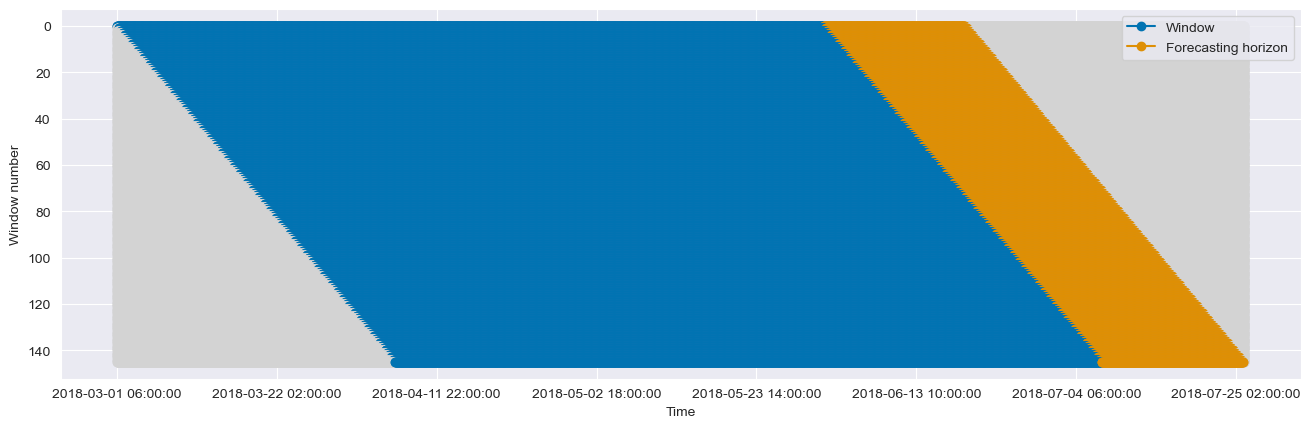

In [41]:
# Plotting sliding windows
plot_windows(cv=cv, y=train_target)

In [42]:
# Training and hypertuning naive forecaster
naive_cv.fit(y=train_target32,X=train_features32)

Fitting 146 folds for each of 8 candidates, totalling 1168 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100...
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442]),
                                                 step_length=6,
                                                 window_length=2210),
                        forecaster=NaiveForecaster(),
                        param_grid={'strategy': ['last', 'mean'],
                                    'window_length': array([79, 82, 85, 88])},
                        verbose=1)

In [43]:
# Getting predictions using training subset
fh = np.arange(1,valid_features.shape[0]+1)

pred = naive_cv.predict(fh=fh,X=valid_features32)
pred

# Displaying RSME score
print('Time Series Forest Regressor RSME: ',np.sqrt(mean_squared_error(valid_target,pred)))

Time Series Forest Regressor RSME:  45.986369694891096


This model essentially predicted the average which led to a high RSME score. Not very practical.

We'll give the TimeSeriesForestRegressor a chance to see if it can come out with the lowest score.

#### TimeSeriesForestRegressor

In [44]:
# Buidling time series regression model 
forest_ts = TimeSeriesForestRegressor(
    n_estimators = 250,
    min_interval = 10,
    random_state=12345)

In [45]:
forest_ts.fit(X=train_features32,y=train_target32)

TimeSeriesForestRegressor(min_interval=7, n_estimators=250, random_state=12345)

In [46]:
pred = forest_ts.predict(valid_features32)
print('TS Forest Regressor RSME: ,',np.sqrt(mean_squared_error(valid_target,pred)))

TS Forest Regressor RSME: , 64.1569198132797


The RMSE score shows this forest regressor isn't a good fit for this time series problem. We'll scrap this model along with the others and move to our final test using the highest scoring model, AutoReg.

## Model Testing
---

#### Benchmark

In [47]:
# Creating benchmark score with dummy
prev_pred = test_target.shift()
prev_pred.iloc[0] = train_target.iloc[-1]

# Scoring dummy model with previous values to compare with median
print('Median orders per hour: ', data['num_orders'].median())
print('Dummy RSME:',mean_absolute_error(test_target,prev_pred))

Median orders per hour:  78.0
Dummy RSME: 45.022624434389144


#### AutoReg Final Test

Being that our test set is non-sequential to the training data the model was trained with, we will need to combine the test set's exogenous data with the validation set's data to sequenced the exog data for prediction.

We'll set the start and end dates on the prediction parameter to match with the test set's index.

In [48]:
# Extracting features within the validation and test set's indices 
test_features = data[valid.index.min():test.index.max()].drop('num_orders',axis=1)

In [49]:
# Scaling the features
test_features = scaler.transform(test_features)

In [50]:
# Making AutoReg model predictions
pred = ar_model.predict(exog_oos=test_features,start=test.index.min(),end=test.index.max())

mean_absolute_error(test_target,pred)

39.51770916698647

## Conclusion
---
In conclusion, this project highlighted the differences in modeling for a time series problem. The strategies are a bit different but share main principles. For one, there are some models that process mutiple features to make predictions vs other that only process labels.

There are concepts for time series models that peek foward past the rolling window as a way of learning but as we have seen in this project, it wasn't very effective in this scenario but could be very effective in other scenarios.

In this project, we found that the AutoRegressive model preformed well given the nature of the data.

If given the necessary analysis, we can find obscure relationships within the data in order to choose the best fitting model for future predictions, which in this case would be a AtuoRegressive or benchmark model.